In [1]:
# add folders to working path

In [2]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FastTensorlineComputation folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FastTensorlineComputation3D")

# Overview

In the following notebook we compute the Poincaré Map of the three-dimensional, steady ABC-flow. The notebook is structured as follows:

1. Define analytic velocity field of the three-dimensional solution of the Euler equations, the steady and spatially periodic Arnold-Beltrami-Childress (ABC) flow:
\begin{equation}
\begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \\ \dot{z}(t) \end{pmatrix} = \begin{pmatrix} u \\ v \\ w \end{pmatrix} = \begin{pmatrix} \sqrt{3}\sin(z)+\cos(y) \\ \sqrt{2}\sin(x) + \sqrt{3}\cos(z) \\ \sin(y)+\sqrt{2}\cos(x) \end{pmatrix}, \quad (x,y,z) \in [0, 2\pi]^3
\label{eq: periodicABC}
\end{equation}
<br />
2. Define computational parameters.
 <br />
3. Define spatio-temporal domain.
 <br />

# Analytic velocity field

Here we define the spatially periodic and steady three dimensional ABC-velocity field.

In [3]:
def velocity(x, y, z):

    u = sqrt(3)*np.sin(z)+np.cos(y)
    v = sqrt(2)*np.sin(x)+sqrt(3)*np.cos(z)
    w = np.sin(y)+sqrt(2)*np.cos(x)
    
    return np.array([u, v, w])

def dudx(x, y, z):
    return 0*x.copy()
def dudy(x, y, z):
    return np.sin(y)
def dudz(x, y, z):
    return sqrt(3)*np.cos(z)
def dvdx(x, y, z):
    return sqrt(2)*np.cos(x)
def dvdy(x, y, z):
    return 0*x.copy()
def dvdz(x, y, z):
    return -sqrt(3)*np.sin(z)
def dwdx(x, y, z):
    return -sqrt(2)*np.sin(x)
def dwdy(x, y, z):
    return np.cos(y)
def dwdz(x, y, z):
    return 0*x.copy()

def vorticity(x, y, z):
    
    #vorticity_x = dwdy(x, y, z)-dudz(x, y, z)
    #vorticity_y = dudz(x, y, z)-dwdx(x, y, z)
    #vorticity_z = dvdx(x, y, z)-dudy(x, y, z)
    
    return velocity(x, y, z)

# Computational parameters

Here we define the computational parameters and the analytic velocity field.

In [4]:
# import numpy
import numpy as np

# import math tools
from math import sqrt, pi

# number of cores to be used for parallel computing
Ncores = 15

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_z = True
periodic = [periodic_x, periodic_y, periodic_z]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [5]:
%%time
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 2*10**4 # float

# Time step-size (in days)
dt = 0.01 # float

# NOTE: For computing the backward trajectories: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 100 # int
Nx = 100 # int
Nz = 100 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]
dz = z_domain[1]-z_domain[0]

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

CPU times: user 8.17 ms, sys: 8.29 ms, total: 16.5 ms
Wall time: 15.2 ms


# Rate of Strain ($ \mathrm{S}(\mathbf{x})$)

In [6]:
%%time
# Import package for parallel computing
from joblib import delayed, Parallel

# Import function to compute velocity
from ipynb.fs.defs.velocity import velocity

def gradient_velocity(x, y, z):
    
    grad_vel = np.array([dudx(x,y,z), dudy(x,y,z), dudz(x,y,z), [dvdx(x,y,z), dvdy(x,y,z), dvdz(x,y,z)], [dwdx(x,y,z), dwdy(x,y,z), dwdz(x,y,z)]])
    
    return grad_vel

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()
z0 = Z_domain.ravel()

# Split x0, y0, z0 into N (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))
z0_batch = list(split(z0, Ncores))

def parallel_S(x, y, z):
    
    # Compute gradient of velocity field
    #grad_vel = gradient_velocity(x0_batch, y0_batch, z0_batch)
    
    grad_vel = np.zeros((3, 3, x.shape[0]))
    
    grad_vel[0,0,:] = dudx(x,y,z)
    grad_vel[1,0,:] = dvdx(x,y,z)
    grad_vel[2,0,:] = dwdx(x,y,z)
    
    grad_vel[0,1,:] = dudy(x,y,z)
    grad_vel[1,1,:] = dvdy(x,y,z)
    grad_vel[2,1,:] = dwdy(x,y,z)
    
    grad_vel[0,2,:] = dudz(x,y,z)
    grad_vel[1,2,:] = dvdz(x,y,z)
    grad_vel[2,2,:] = dwdz(x,y,z)
    
    # Compute rate of strain tensor
    S = .5*(grad_vel+grad_vel.transpose(1,0,2))

    return S

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract rate of strain tensor from results of parallel computation
S = results[0]

for i in range(1,len(results)):
    
    S = np.append(S, results[i], axis = 2)

# Reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1], X_domain.shape[2]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1], X_domain.shape[2]))
S = S.reshape((3, 3, X_domain.shape[0], X_domain.shape[1], X_domain.shape[2]))

CPU times: user 380 ms, sys: 373 ms, total: 753 ms
Wall time: 891 ms


# Compute eigenvalues/eigenvectors of rate of strain

In [7]:
%%time
# Import package to compute eigenvalues of 3x3 matrix
from ipynb.fs.defs.eigen import eigen

from tqdm.notebook import tqdm

def parallel_eigen(i):
    
    eigenvalue_parallel = np.zeros((X_domain.shape[1], X_domain.shape[2], 3, 3))*np.nan
    eigenvector_parallel = np.zeros((X_domain.shape[1], X_domain.shape[2], 3, 3))*np.nan
    
    for j in range(X_domain.shape[1]):
        
        for k in range(Z_domain.shape[2]):
            
            eigenvalue, eigenvector = eigen(S[:,:,i,j,k])
        
            eigenvalue_parallel[j,k,:,:] = np.diag(eigenvalue)
            eigenvector_parallel[j,k,:,:] = eigenvector
        
    return eigenvalue_parallel, eigenvector_parallel

results_eigen = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_eigen)(i) for i in tqdm(range(X_domain.shape[2]))))

#eigenvalues and eigenvectors
eigenvalues = results_eigen[:,0,:,:,:,:]
eigenvectors = results_eigen[:,1,:,:,:,:]
smax = eigenvalues[:,:,:,0,0]
smid = eigenvalues[:,:,:,1,1]
smin = eigenvalues[:,:,:,2,2]
eigenvector_max = eigenvectors[:,:,:,:,0]
eigenvector_mid = eigenvectors[:,:,:,:,1]
eigenvector_min = eigenvectors[:,:,:,:,2]

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 393 ms, sys: 172 ms, total: 564 ms
Wall time: 8.3 s


## Compute Tensorfield properties

We now compute the properties of the rate of strain tensor 'S' such as the eigenvalues 's1', 's2', 's3' and eigenvectors 'eigenv1', 'eigenv2', 'eigenv3'. Furthermore, we also need the spatial derivatives of the elements of 'S'.

In [8]:
%%time
# Import (cubic) RectangularGridInterpolat from scipy
from scipy.interpolate import RegularGridInterpolator
        
# Compute gradients of elements of rate of strain tensor
S11 = np.nan_to_num(S[0,0,:,:,:], nan=0.0)
S12 = np.nan_to_num(S[0,1,:,:,:], nan=0.0)
S22 = np.nan_to_num(S[1,1,:,:,:], nan=0.0)
S33 = np.nan_to_num(S[2,2,:,:,:], nan=0.0)
S23 = np.nan_to_num(S[1,2,:,:,:], nan=0.0)
S13 = np.nan_to_num(S[0,2,:,:,:], nan=0.0)

# Interpolate elements of rate of strain tensor (per default: cubic)
interpS11 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S11)
interpS12 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S12)
interpS22 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S22)
interpS33 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S33)
interpS23 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S23)
interpS13 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S13)

interp_s_max = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), smax)
interp_s_mid = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), smid)
interp_s_min = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), smin)

interp_xi_max_x = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), eigenvector_max[:,:,:,0])
interp_xi_max_y = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), eigenvector_max[:,:,:,1])
interp_xi_max_z = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), eigenvector_max[:,:,:,2])

interp_xi_min_x = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), eigenvector_min[:,:,:,0])
interp_xi_min_y = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), eigenvector_min[:,:,:,1])
interp_xi_min_z = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), eigenvector_min[:,:,:,2])

interp_xi_mid_x = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), eigenvector_mid[:,:,:,0])
interp_xi_mid_y = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), eigenvector_mid[:,:,:,1])
interp_xi_mid_z = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), eigenvector_mid[:,:,:,2])

CPU times: user 83.7 ms, sys: 26.5 ms, total: 110 ms
Wall time: 109 ms


# Classic tensorline integration

In [18]:
from time import perf_counter

def RK4_classic_tensorline(x, x_prime_before, ds, interp_x, interp_y, interp_z):
    
    # Define starting point.
    x1 = x
    
    x1_interp = x1%(2*pi)
    
    # Compute x_prime at the beginning of the time-step
    x_prime_x = interp_x(x1_interp)
    x_prime_y = interp_y(x1_interp)
    x_prime_z = interp_z(x1_interp)
    x_prime = np.array([x_prime_x, x_prime_y, x_prime_z]).transpose()
    
    x_prime_reoriented = x_prime.copy()
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    k1 = ds * x_prime_reoriented

    #  position and time at the first midpoint.
    x2 = x1 + .5 * k1
    
    x2_interp = x2%(2*pi)
    
    # Compute x_prime at the first midpoint.
    x_prime_x = interp_x(x2_interp)
    x_prime_y = interp_y(x2_interp)
    x_prime_z = interp_z(x2_interp)
    x_prime = np.array([x_prime_x, x_prime_y, x_prime_z]).transpose()
    
    x_prime_reoriented = x_prime.copy()
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k2 = ds * x_prime_reoriented

    # Update position at the second midpoint.
    x3 = x1 + .5 * k2
    
    x3_interp = x3%(2*pi)
    
    # Compute x_prime at the second midpoint.
    x_prime_x = interp_x(x3_interp)
    x_prime_y = interp_y(x3_interp)
    x_prime_z = interp_z(x3_interp)
    x_prime = np.array([x_prime_x, x_prime_y, x_prime_z]).transpose()

    x_prime_reoriented = x_prime.copy()
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k3 = ds * x_prime_reoriented
    
    # Update position at the endpoint.
    x4 = x1 + k3
    
    x4_interp = x4%(2*pi)
    
    # Compute x_prime at the endpoint.
    x_prime_x = interp_x(x4_interp)
    x_prime_y = interp_y(x4_interp)
    x_prime_z = interp_z(x4_interp)
    x_prime = np.array([x_prime_x, x_prime_y, x_prime_z]).transpose()
    
    x_prime_reoriented = x_prime.copy()
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k4 = ds * x_prime_reoriented
    
    x_prime_avg = 1.0/6.0*(k1+2*k2+2*k3+k4)
    x_update = x+x_prime_avg
    
    return x_update, x_prime_avg

x_domain_poincare = np.linspace(xmin, xmax, 10, endpoint = True) # array (10, )
y_domain_poincare = np.linspace(ymin, ymax, 10, endpoint = True) # array (10, )
z_domain_poincare = np.linspace(zmin, zmax, 10, endpoint = True) # array (10, )

dx = x_domain_poincare[1]-x_domain_poincare[0]
dy = y_domain_poincare[1]-y_domain_poincare[0]
dz = z_domain_poincare[1]-z_domain_poincare[0]

X_domain_poincare, Y_domain_poincare, Z_domain_poincare = np.meshgrid(x_domain_poincare, y_domain_poincare, z_domain_poincare) # array (10, 10, 10) 

# Vectorize initial conditions by arranging them to a vector of size (10*10*10, 3)
x0 = X_domain_poincare[:,:,0].ravel()
y0 = Y_domain_poincare[:,:,0].ravel()
z0 = Z_domain_poincare[:,:,0].ravel()

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0, Ncores)) # list (Nx*Ny*Nz)

ds = 0.1
s_range = np.arange(0, 1*10**4, ds)

def parallel_tensorlines(x0, y0, z0):
    
    X0 = np.zeros((x0.shape[0], 3))

    X0[:,0] = x0
    X0[:,1] = y0
    X0[:,2] = z0

    x_prime_before = np.zeros(X0.shape)
    x_prime_before[:,0] = 1
    
    X_tensorlines = np.zeros((len(s_range), X0.shape[0], X0.shape[1]))
    X_tensorlines[0,:,:] = X0.copy()
    
    for s in range(len(s_range)-1):
        if np.around(s/len(s_range), 3) % 0.01 == 0:
            print("Percentage completed: ", int(100*s/len(s_range)))
        X_tensorlines[s+1,:,:], x_prime_before = RK4_classic_tensorline(X_tensorlines[s,:,:], x_prime_before, ds, interp_xi_mid_x, interp_xi_mid_y, interp_xi_mid_z)
        
    return X_tensorlines
    
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_tensorlines)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:  1.4min remaining:  9.0min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  1.4min remaining:   41.6s


KeyboardInterrupt: 

In [15]:
X_tensorlines = results[0]

for res in results[1:]:
    X_tensorlines = np.append(X_tensorlines, res, axis = 1)
    
print(X_tensorlines.shape)

(100000, 1000, 3)


  0%|          | 0/1000 [00:00<?, ?it/s]

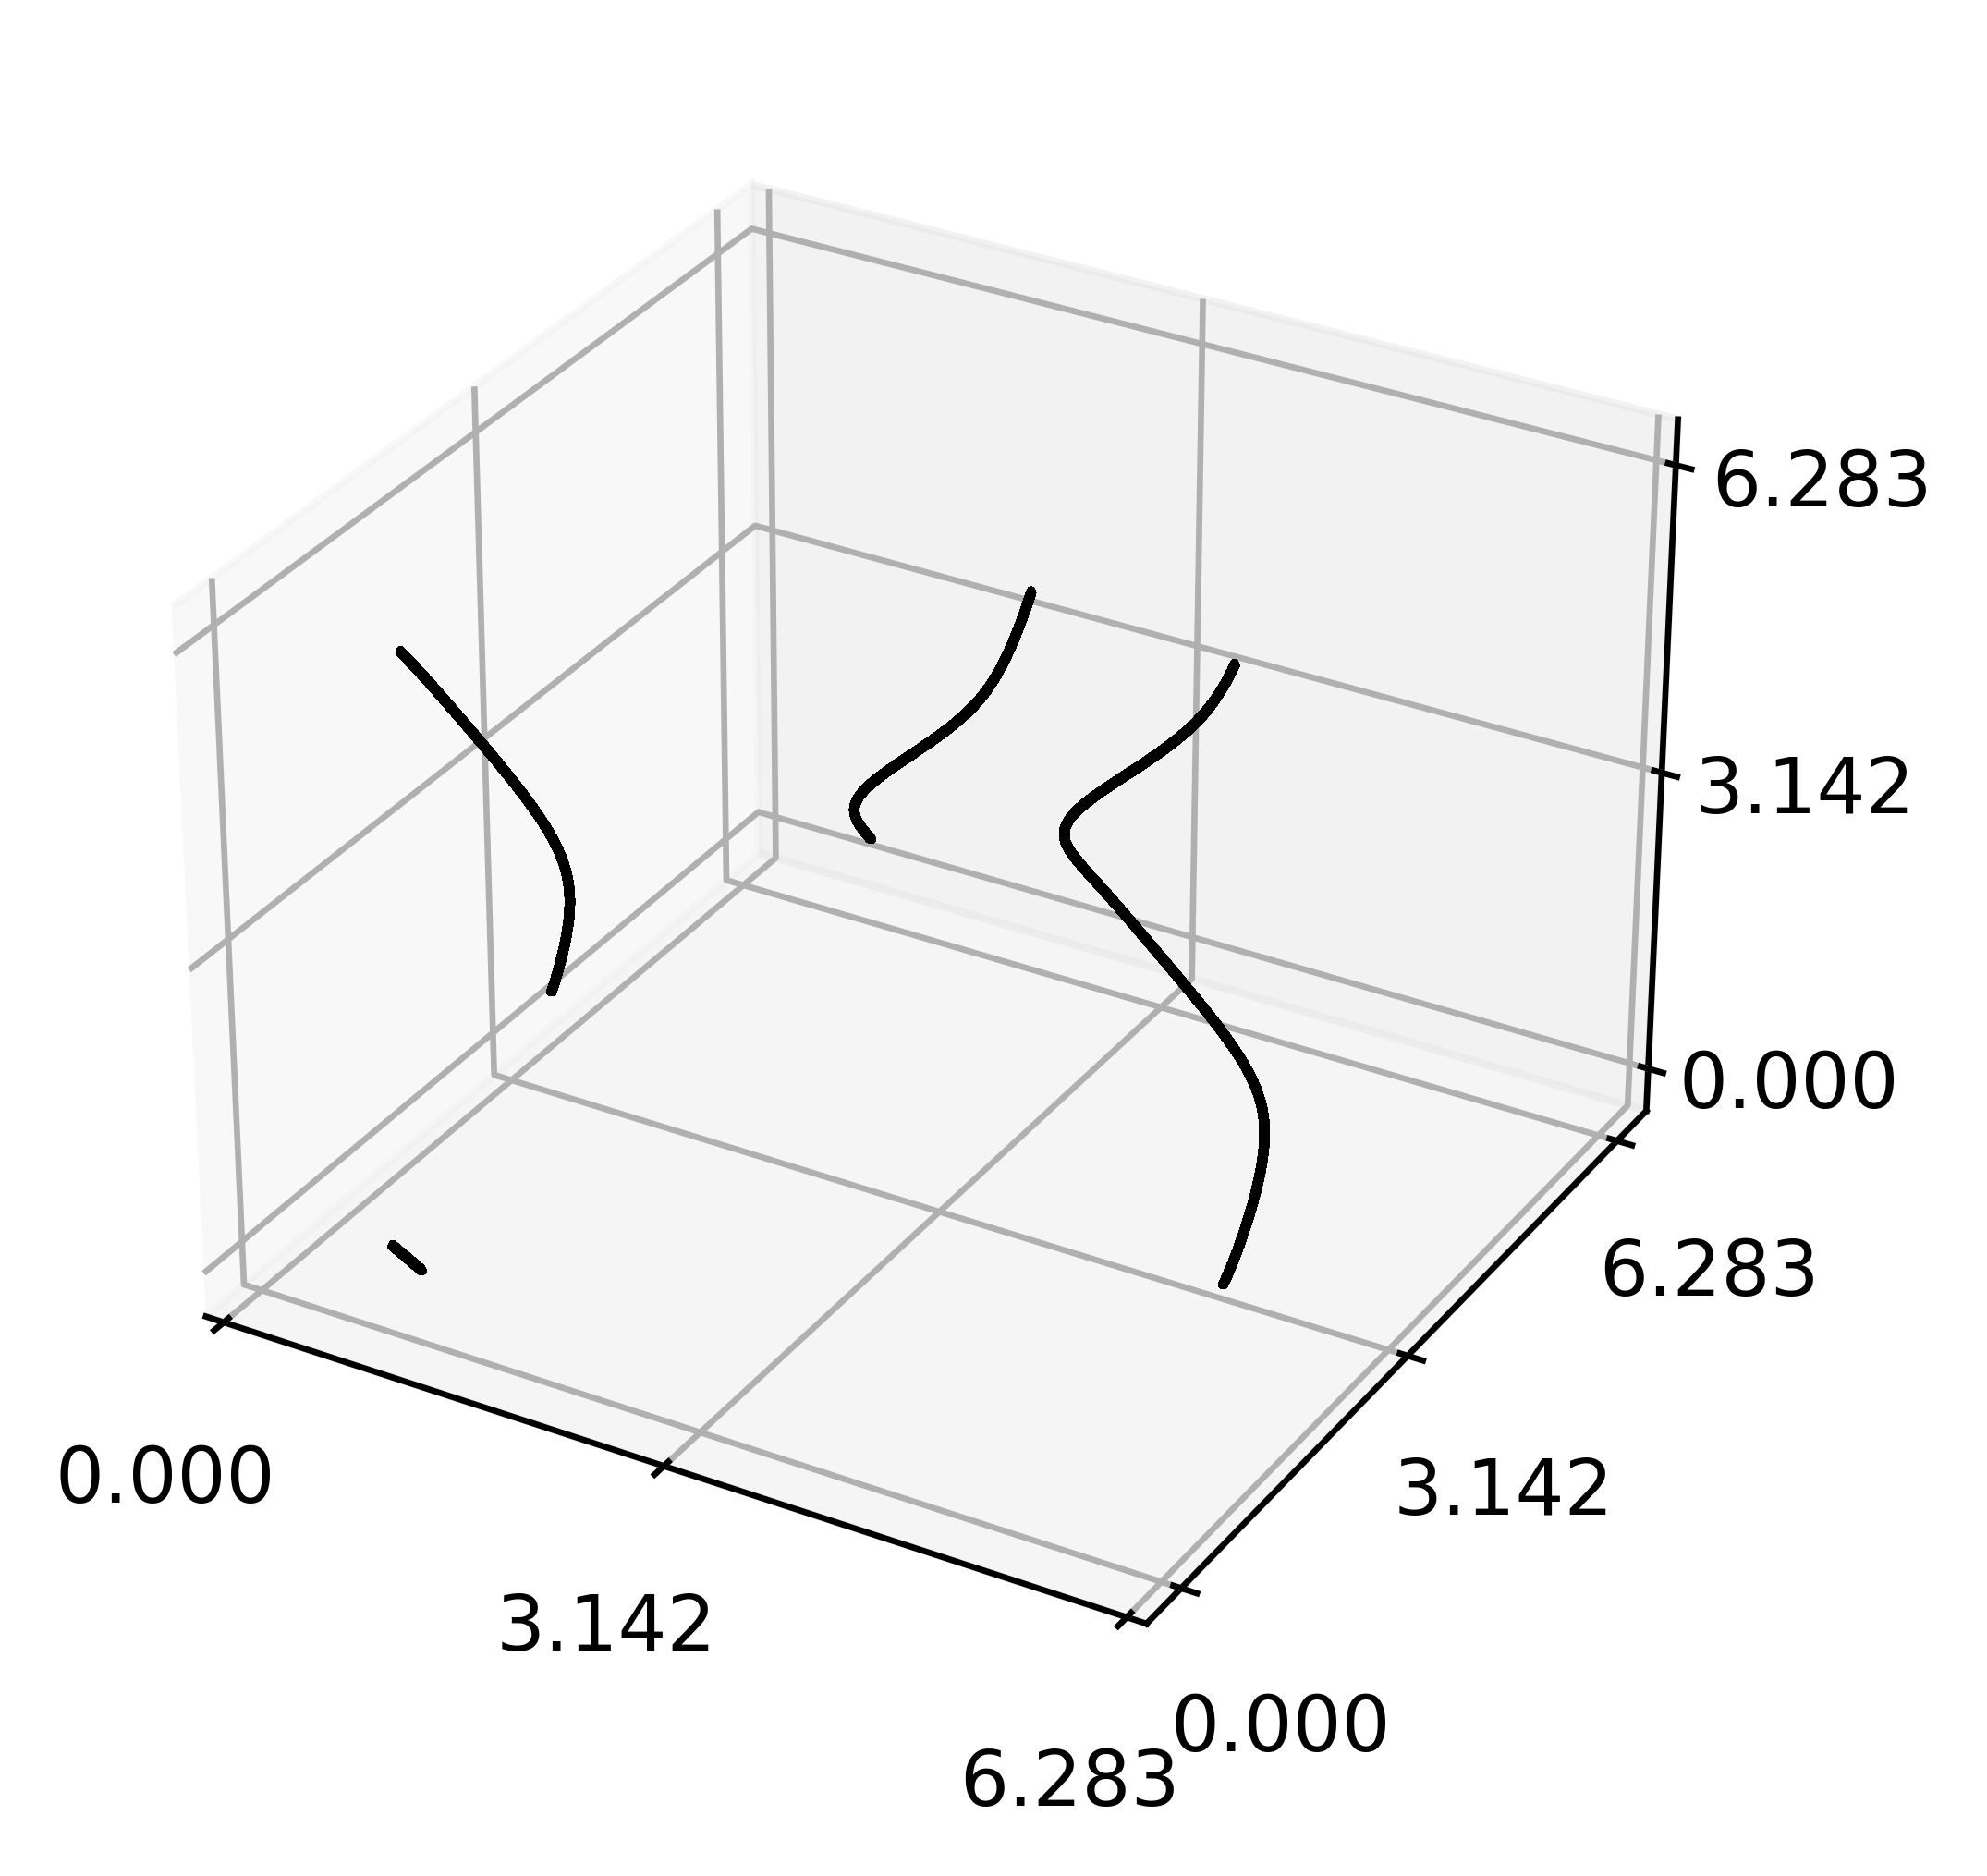

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes(projection = '3d')
for i in tqdm(range(X_tensorlines.shape[1])):
    ax.scatter(X_tensorlines[-500:,i,0]%(2*pi), X_tensorlines[-500:,i,1]%(2*pi), X_tensorlines[-500:,i,2]%(2*pi), s = 0.1, marker = "^", c = "k")

ax.set_xticks([0, pi, 2*pi])    
ax.set_yticks([0, pi, 2*pi])   
ax.set_zticks([0, pi, 2*pi])   
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

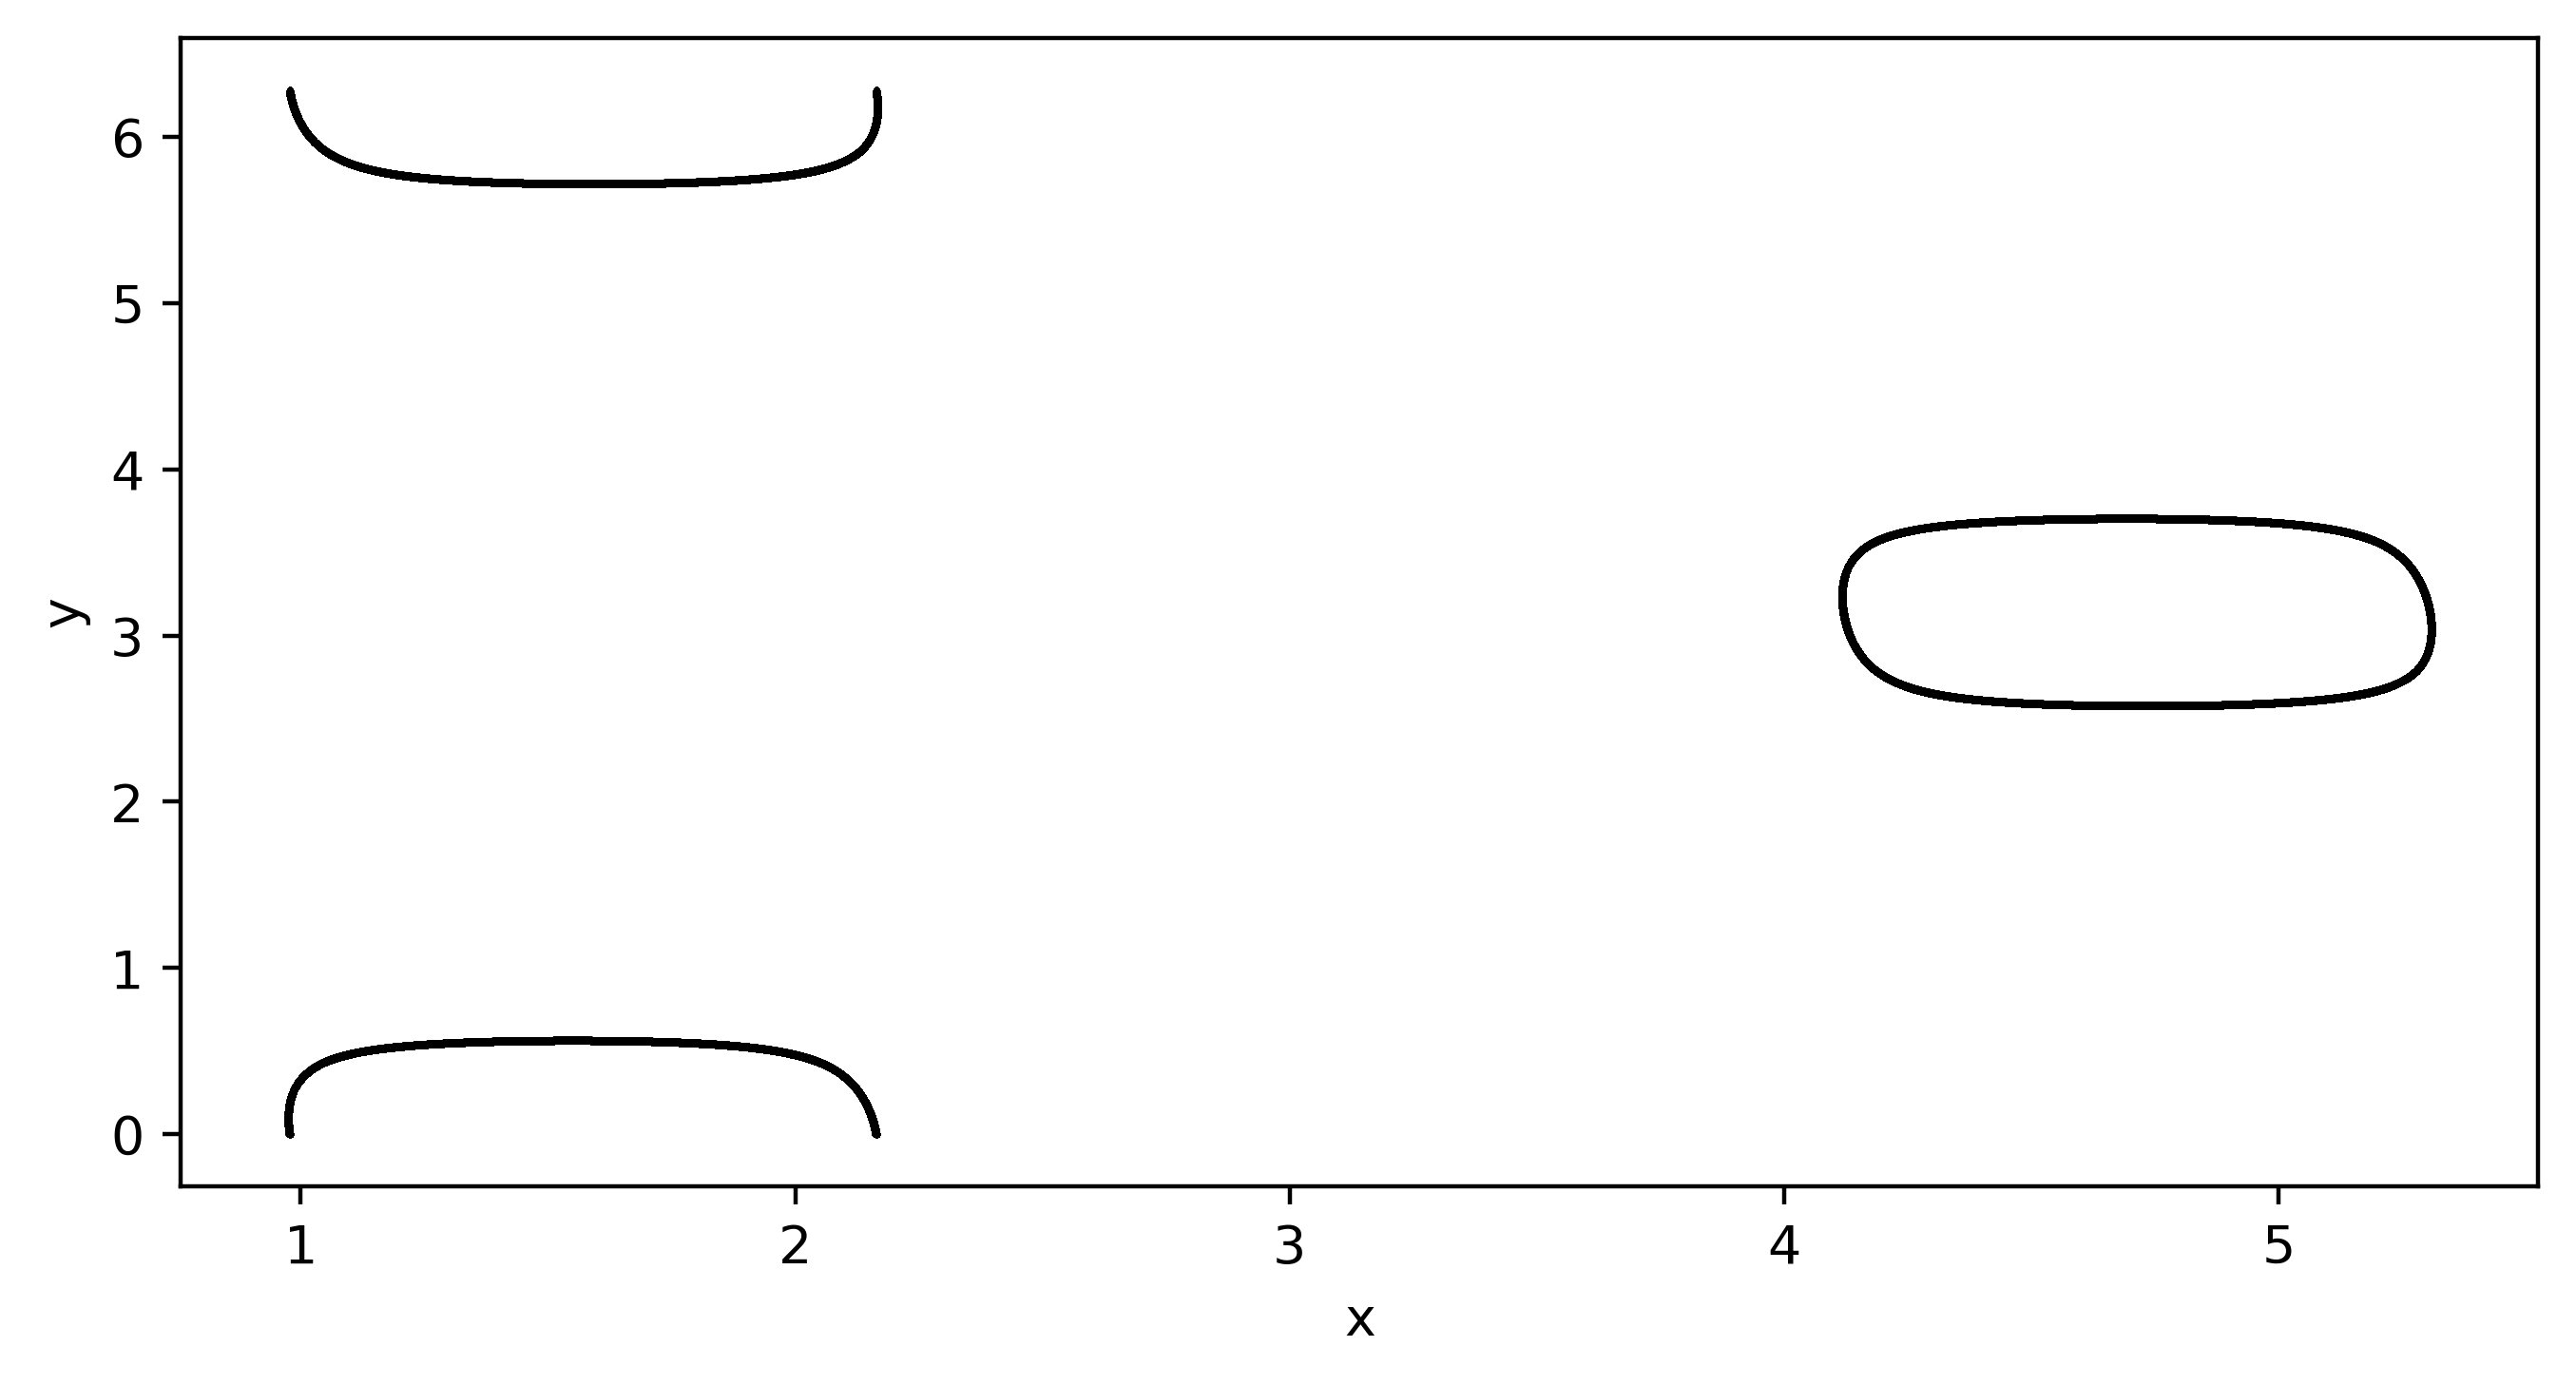

  0%|          | 0/1000 [00:00<?, ?it/s]

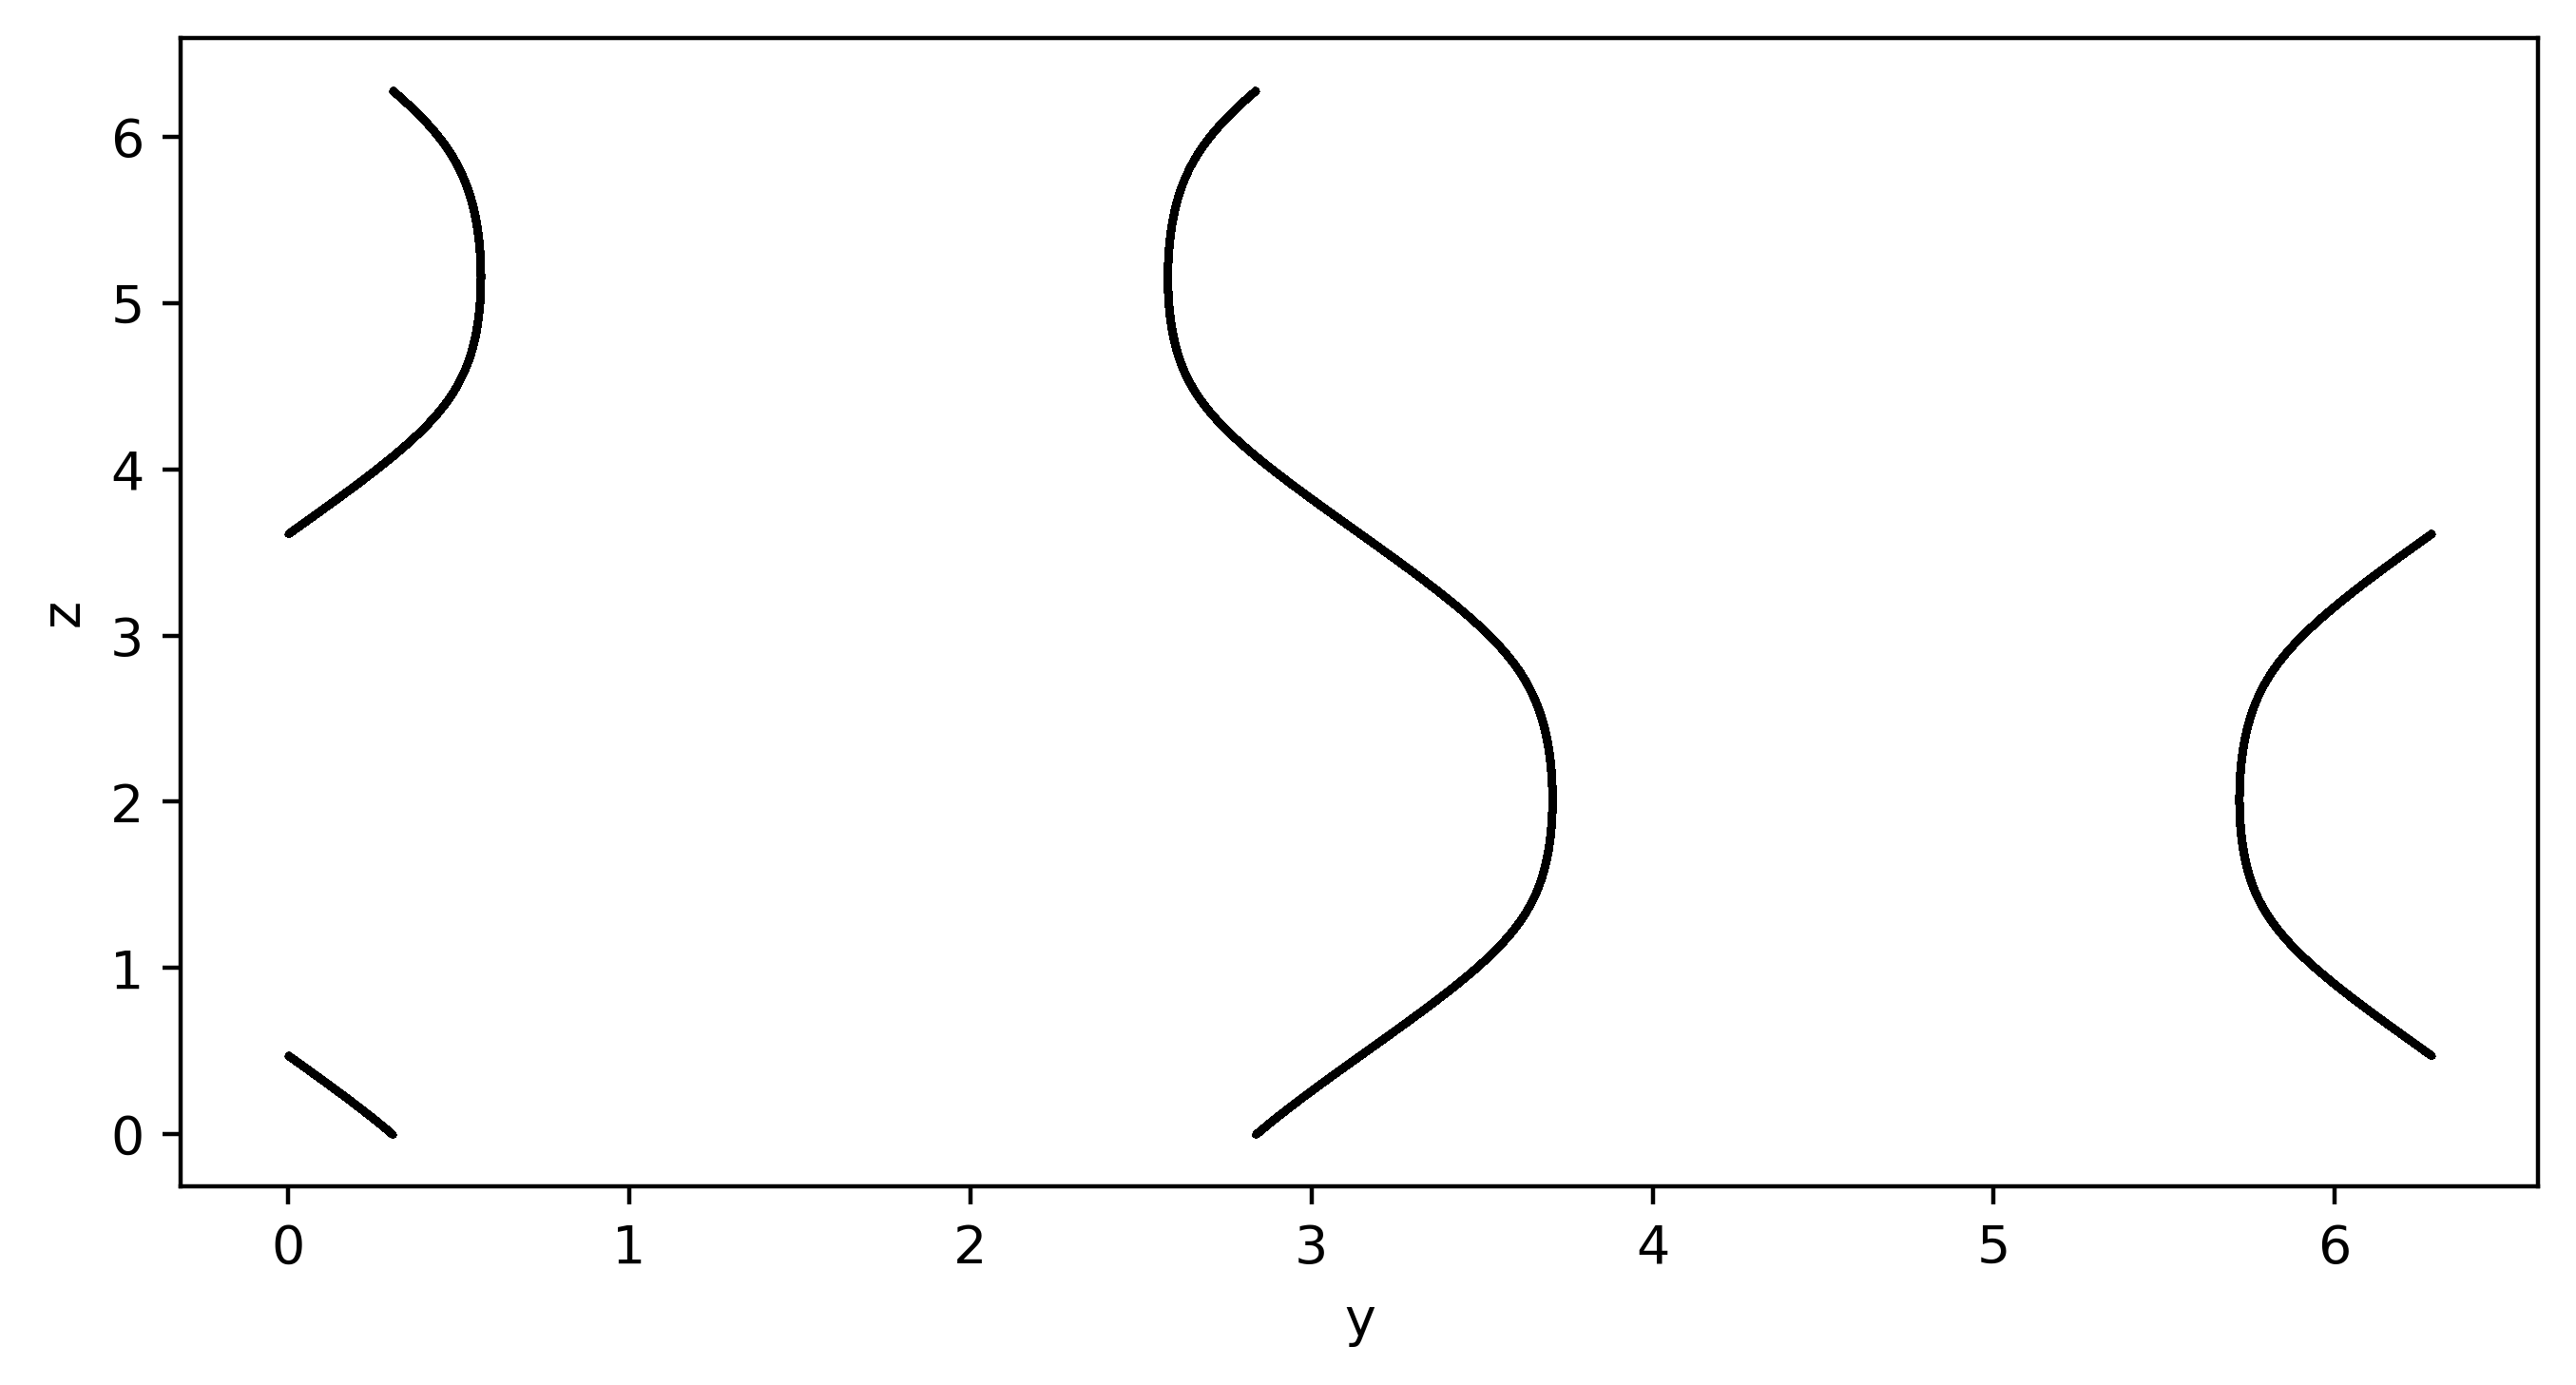

  0%|          | 0/1000 [00:00<?, ?it/s]

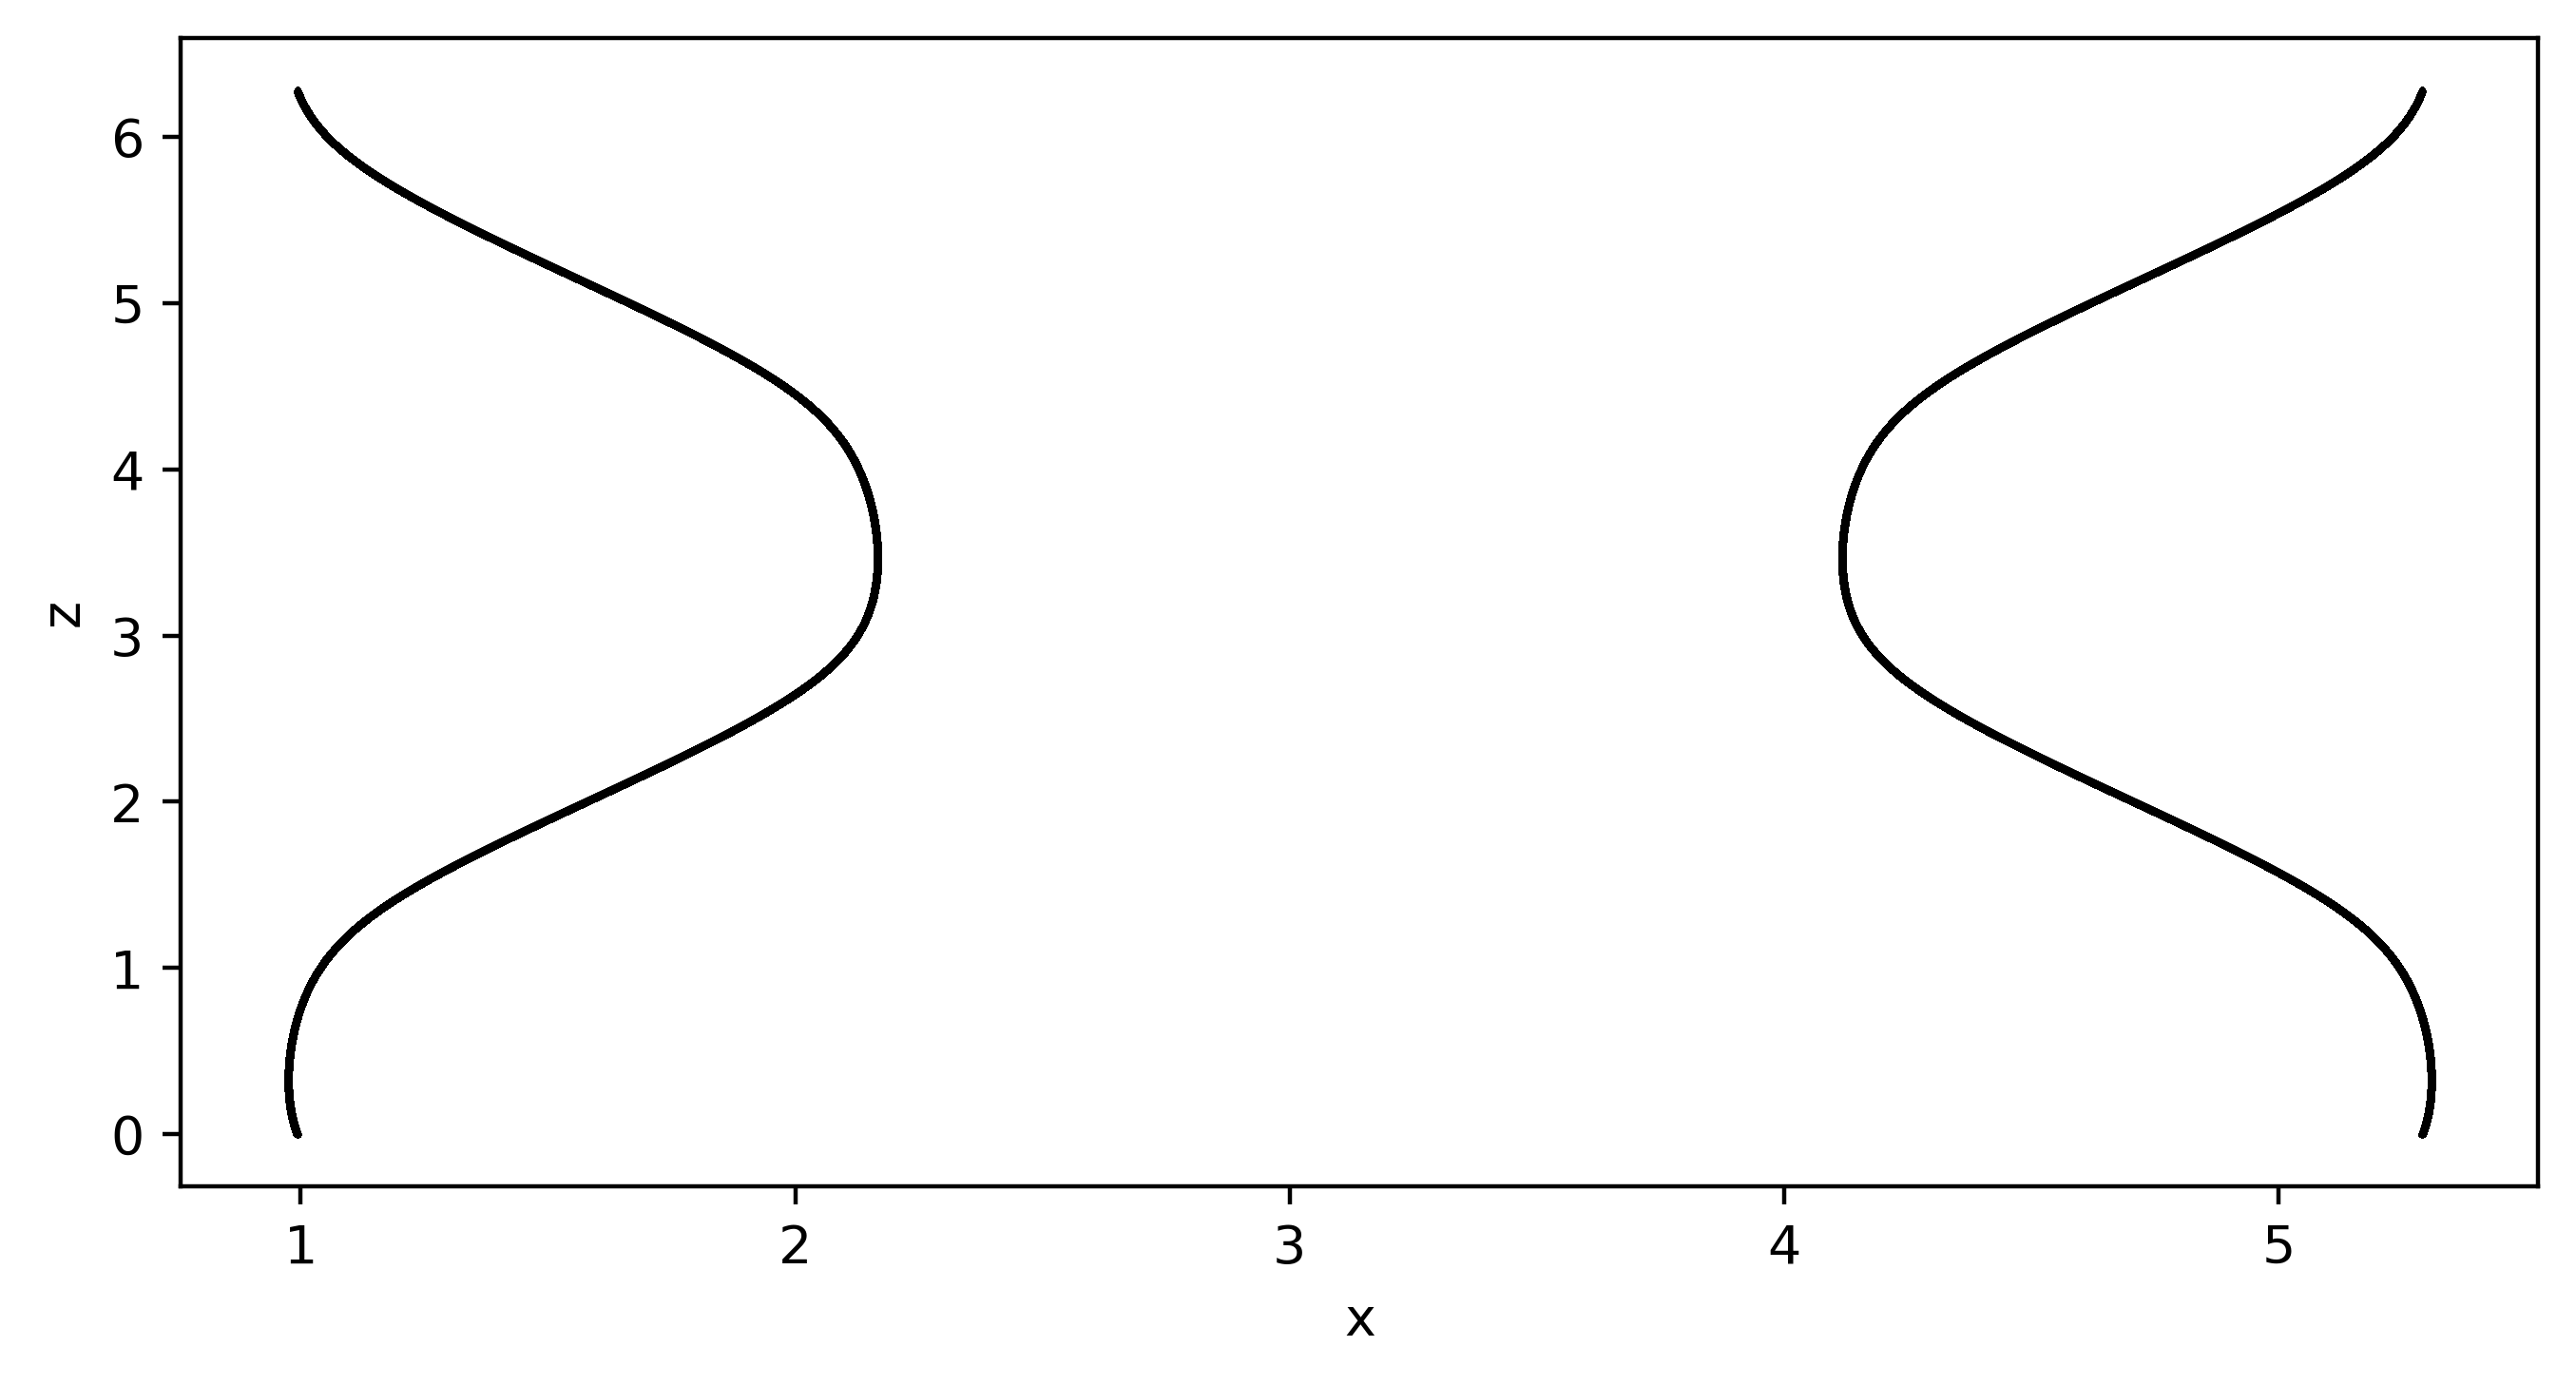

In [17]:
fig = plt.figure(figsize = (8, 4), dpi = 400)
ax = plt.axes()
for i in tqdm(range(X_tensorlines.shape[1])):
    ax.scatter(X_tensorlines[-1000:,i,0]%(2*pi), X_tensorlines[-1000:,i,1]%(2*pi), s = 0.1, marker = "^", c = "k")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

fig = plt.figure(figsize = (8, 4), dpi = 400)
ax = plt.axes()
for i in tqdm(range(X_tensorlines.shape[1])):
    ax.scatter(X_tensorlines[-1000:,i,1]%(2*pi), X_tensorlines[-1000:,i,2]%(2*pi), s = 0.1, marker = "^", c = "k")
ax.set_xlabel("y")
ax.set_ylabel("z")
plt.show()

fig = plt.figure(figsize = (8, 4), dpi = 400)
ax = plt.axes()
for i in tqdm(range(X_tensorlines.shape[1])):
    ax.scatter(X_tensorlines[-1000:,i,0]%(2*pi), X_tensorlines[-1000:,i,2]%(2*pi), s = 0.1, marker = "^", c = "k")
ax.set_xlabel("x")
ax.set_ylabel("z")
plt.show()

In [ ]:
# Import package for parallel computing
from joblib import delayed, Parallel

# Import 1D cubic spline interpolant
from scipy.interpolate import CubicSpline

# Import 1D linear interpolant
from scipy.interpolate import interp1d

# import math tools
from math import pi

def parallel_PoincareMap(time, Fmap, t0, tN):
    
    # CubicSpline Interpolation for x,y and z component of the trajectories
    cs_x = CubicSpline(time, Fmap[:,0])
    cs_y = CubicSpline(time, Fmap[:,1])
    cs_z = CubicSpline(time, Fmap[:,2])
    
    # time-interval [10^4, 2*10^4] (long-term behaviour of trajectories)
    time_poincare = np.arange(t0, tN, dt)
    
    # evaluate long-term behaviour of x,y and z component
    x_interp = cs_x(time_poincare)
    y_interp = cs_y(time_poincare)
    z_interp = cs_z(time_poincare)
    
    x_intersec, y_intersec, z_intersec = [], [], []
    
    # iterate along long-term trajectories 
    for i in range(len(z_interp)-1):
        
        if np.abs(z_interp[i]%(2*pi)-z_interp[i+1]%(2*pi)) > pi:
            
            z_interp_shifted = z_interp[i:i+2]-np.around((z_interp[i]/(2*pi)), 0)*2*pi
            
            root = -z_interp_shifted[0]*dt/(z_interp_shifted[1]-z_interp_shifted[0])+time_poincare[i]
            x_intersec.append(cs_x(root)%(2*pi))
            y_intersec.append(cs_y(root)%(2*pi))
            z_intersec.append(cs_z(root)%(2*pi))
    
    return x_intersec, y_intersec, z_intersec

results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_PoincareMap)(s_range, X_tensorlines[:,i,:], t0=0.5*s_range[-1], tN=s_range[-1]) for i in range(X_tensorlines.shape[1]))

x_intersec, y_intersec, z_intersec = [], [], []

for res in results:
    for i in range(len(res[0])):
        x_intersec.append(res[0][i])
        y_intersec.append(res[1][i])
        z_intersec.append(res[2][i])

In [ ]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Poincare Map
ax.scatter(x_intersec, y_intersec, c = "b", s = 0.2)

# Axis Labels
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Axis limits
ax.set_xlim([0, 2*pi])
ax.set_ylim([0, 2*pi])

# Title
ax.set_title(r'Poincaré Map with Poincaré section z=0', fontsize = 10)

plt.show()

In [ ]:
# import math tools
from math import atan, acos, asin, cos, sin, sqrt

# Import package to compute tensorline equation using ODE solver
from ipynb.fs.defs.tensorline_equation import _tensorline_equation

# Import package to compute tensorlines by re-orienting the vectorfield on the fly
from ipynb.fs.defs.RK4_tensorlines import _RK4_tensorlines

# Import package to solve ODE
from scipy.integrate import solve_ivp

# import plotting library
import matplotlib.pyplot as plt

# define integration interval of dummy variable 's'
t = [0, 10]
t_eval = np.linspace(t[0], t[-1], 1000)

# initial alignment of eigenvector
init_orientation = np.array([0, 0, 1])

# define eigenvector_field 
# {0: eigenvector field of maximum eigenvalue}
# {1: eigenvector field of middle eigenvalue}
# {2: eigenvector field of minimum eigenvalue}
idx_eigenvector = 0

counter = 0

def terminate_ODE(t, x_phi, interpS11, interpS12, interpS13, interpS22, interpS23, interpS33, aux_grid, idx_eigenvector):
                
    x = x_phi[0]%(2*pi)
    y = x_phi[1]%(2*pi)
    z = x_phi[2]%(2*pi)
    
    # compute gradient of velocity
    grad_vel = gradient_velocity(0, np.array([x, y, z]), X, Y, Z, Interpolant, periodic, bool_unsteady, aux_grid)
    
    # compute rate of strain
    S = RateStrain(grad_vel)
    
    # compute eigenvalues/eigenvectors of rate of strain
    lam = eigen(S)[0]
            
    event = abs(lam[0]-lam[1]) <= .01 or abs(lam[0]-lam[2]) <= .01 or abs(lam[1]-lam[2]) <= .01
                
    return 1-event
            
terminate_ODE.terminal = True

for i in range(0, X_domain.shape[0], 5):
    for j in range(0, Y_domain.shape[1], 5):
        for k in range(0, Z_domain.shape[2], 5):
            
            # initial position of particle
            xinit = np.array([X_domain[i, j, k], Y_domain[i, j, k], Z_domain[i, j, k]])
            
            # compute gradient of velocity
            grad_vel = gradient_velocity(t[0], xinit, X, Y, Z, Interpolant, periodic, bool_unsteady, aux_grid)
        
            # compute rate of strain
            S = RateStrain(grad_vel)
            
            # compute inital eigenvector orientation
            lamda, eigenv = eigen(S)
            initial_vector = eigenv[:,idx_eigenvector]
            print("initial particle position: ", xinit)
            if np.sign(init_orientation@initial_vector) < 0:
                initial_vector = -initial_vector
            
            if initial_vector[0] < 0 or initial_vector[1] < 0:
                phi0 = atan(initial_vector[1]/initial_vector[0])+pi
            else:
                phi0 = atan(initial_vector[1]/initial_vector[0])
            theta0 = acos(initial_vector[2])
                
            x0 = np.array([X_domain[i, j, k], Y_domain[i, j, k], Z_domain[i, j, k], phi0, theta0])
            
            # Compute tensorline by re-orienting vector field
            ds = t_eval[1]-t_eval[0]
            x_oriented = x0[:3].copy()
            x_prime = initial_vector.copy()
            trajectory_oriented = [[], [], []]
            trajectory_oriented[0].append(x_oriented[0])
            trajectory_oriented[1].append(x_oriented[1])
            trajectory_oriented[2].append(x_oriented[2])   
            phi_oriented, theta_oriented = [], []
            print("initial vector: ", x_prime)
            
            for idx_t in range(len(t_eval)):             
                x_oriented, x_prime = _RK4_tensorlines(X, Y, Z, x, x_prime, ds, periodic, interpS11, interpS12, interpS13, interpS22, interpS23, interpS33, idx_eigenvector)
                trajectory_oriented[0].append(x_oriented[0])
                trajectory_oriented[1].append(x_oriented[1])
                trajectory_oriented[2].append(x_oriented[2])   
                vx = x_prime[0]
                vy = x_prime[1]
                vz = x_prime[2]
                norm_v = sqrt(vx**2+vy**2+vz**2)
                if norm_v == 0:
                    phi_oriented.append(np.nan)
                    theta_oriented.append(np.nan)                   
                else:
                    if vx < 0:
                        phi_oriented.append((atan(vy/vx)+pi)%(2*pi))
                    else:
                        phi_oriented.append((atan(vy/vx))%(2*pi))
                    theta_oriented.append(acos(vz/norm_v))
            
            # solve ODE for tensorlines maximum eigenvector field of rate of strain
            solODE = solve_ivp(_tensorline_equation, t, x0, 'RK45', t_eval, rtol=1e-5, atol=1e-5, args=(interpS11, interpS12, interpS13, interpS22, interpS23, interpS33, aux_grid, idx_eigenvector))
                               
            x = solODE.y[0,:]%(2*pi)
            y = solODE.y[1,:]%(2*pi)
            z = solODE.y[2,:]%(2*pi)
            phi = solODE.y[3,:]%(2*pi)
            theta = solODE.y[4,:]%pi
            
            lam1_2, lam2_3, lam1_3 = [], [], []
            
            for ii in range(x.shape[0]):
                
                S11 = interpS11([y[ii], x[ii], z[ii]])[0]
                S12 = interpS12([y[ii], x[ii], z[ii]])[0]
                S22 = interpS22([y[ii], x[ii], z[ii]])[0]
                S13 = interpS13([y[ii], x[ii], z[ii]])[0]
                S23 = interpS23([y[ii], x[ii], z[ii]])[0]
                S33 = interpS33([y[ii], x[ii], z[ii]])[0]
    
                S21 = S12.copy()
                S31 = S13.copy()
                S32 = S23.copy()
    
                S = np.array([[S11, S12, S13], [S21, S22, S23], [S31, S32, S33]])
                lam = eigen(S)[0]
                lam1_2.append(abs(lam[0]-lam[1]))
                lam1_3.append(abs(lam[0]-lam[2]))
                lam2_3.append(abs(lam[1]-lam[2]))
                
            # plot trajectory in 3D
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (14, 10), dpi = 500)
            ax1.scatter(trajectory_oriented[0][::10], trajectory_oriented[1][::10], facecolor = "None", edgecolor = "r", label = r'manual', marker = "o", s = 50)
            ax2.scatter(trajectory_oriented[0][::10], trajectory_oriented[2][::10], facecolor = "None", edgecolor = "r", label = r'manual', marker = "o", s = 50)
            ax3.scatter(trajectory_oriented[1][::10], trajectory_oriented[2][::10], facecolor = "None", edgecolor = "r", label = r'manual', marker = "o", s = 50)
            ax1.scatter(x[::10], y[::10], marker = "^", label = r'automatic', s = 50, facecolor = "None", edgecolor = "b")
            ax1.set_xlabel("x")
            ax1.set_ylabel("y")
            ax1.set_title("projection onto x/y plane")
            ax2.set_xlabel("x")
            ax2.set_ylabel("z")
            ax2.scatter(x[::10], z[::10], marker = "^", label = r'automatic', s = 50, facecolor = "None", edgecolor = "b")
            ax2.set_title("projection onto x/z plane")
            ax3.scatter(y[::10], z[::10], marker = "^", label = r'automatic', s = 50, facecolor = "None", edgecolor = "b")
            ax3.set_xlabel("y")
            ax3.set_ylabel("z")
            ax3.set_title("projection onto y/z plane")
            ax4.scatter(phi, theta, label = r'automatic', marker = "^", s = 50, facecolor = "None", edgecolor = "b")
            ax4.scatter(phi_oriented, theta_oriented, label = r'manual', marker = "o", s = 50, facecolor = "None", edgecolor = "r")
            ax4.set_xlabel(r'$\phi$')
            ax4.set_ylabel(r'$\theta$')
            ax4.set_title(r'$ \theta - \phi $')
            ax1.scatter(trajectory_oriented[0][0], trajectory_oriented[1][0], c = "b", marker = "^", s = 100)
            ax2.scatter(trajectory_oriented[0][0], trajectory_oriented[2][0], c = "b", marker = "^", s = 100)
            ax3.scatter(trajectory_oriented[1][0], trajectory_oriented[2][0], c = "b", marker = "^", s = 100)
            plt.legend(loc="upper right", fontsize = 10)
            
            plt.savefig('./Fig/max/fig_'+np.str(int(counter)) + '.jpg')
            counter += 1
            plt.show()